In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import onnx

import pandas as pd
import numpy as np
import onnxruntime as rt

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# constants and parameters definition

data_path = '../data/300k_dataset.csv'
model1_path = '../Group 9/model_1.onnx'
model2_path = '../Group 9/model_2.onnx'

In [3]:
def impact_disparity_test(
        model_path, data_address, sensitive_attributes=None, selection_threshold=0.8, bins=5
):
    data = pd.read_csv(data_address)
    excluded_columns = ['checked', 'Ja', 'Nee']
    X = data.drop(excluded_columns, axis=1, errors='ignore').astype(np.float32)

    session = rt.InferenceSession(model_path)
    input_name = session.get_inputs()[0].name

    results = {}

    attributes_to_test = sensitive_attributes if sensitive_attributes else [col for col in data.columns if col not in excluded_columns]

    for attr in attributes_to_test:
        # Check if the feature is continuous or binary
        unique_values = data[attr].dropna().unique()

        if len(unique_values) == 2 and set(unique_values).issubset({0, 1}):  # Binary attribute
            group_0 = data[data[attr] == 0]
            group_1 = data[data[attr] == 1]
            
            preds_0 = session.run(None, {input_name: group_0.drop(excluded_columns, axis=1, errors='ignore').astype(np.float32).values})[0]
            preds_1 = session.run(None, {input_name: group_1.drop(excluded_columns, axis=1, errors='ignore').astype(np.float32).values})[0]

            if preds_0.ndim > 1:
                preds_0 = np.argmax(preds_0, axis=1)
            if preds_1.ndim > 1:
                preds_1 = np.argmax(preds_1, axis=1)

            prob_0 = np.sum(preds_0) / len(preds_0) if len(preds_0) > 0 else 0
            prob_1 = np.sum(preds_1) / len(preds_1) if len(preds_1) > 0 else 0

            impact_disparity = min(prob_1 / prob_0, prob_0 / prob_1) if prob_0 > 0 and prob_1 > 0 else float('inf')

            results[attr] = {
                "group_0_size": len(group_0),
                "group_1_size": len(group_1),
                "prob_0": prob_0,
                "prob_1": prob_1,
                "impact_disparity": impact_disparity,
                "passes_threshold": impact_disparity >= selection_threshold
            }

        else:  # Continuous attribute
# Split into 5 groups manually
            data_sorted = data[[attr]].sort_values(by=attr).dropna()
            group_size = len(data_sorted) // bins
            bin_probs = {}
            bin_sizes = {}

            for i in range(bins):
                start = i * group_size
                end = (i + 1) * group_size if i < bins - 1 else len(data_sorted)
                group_data = data_sorted.iloc[start:end]

                # Filter the corresponding rows in the full dataset
                bin_data = data[data[attr].isin(group_data[attr])]
                bin_X = bin_data.drop(excluded_columns, axis=1, errors='ignore').astype(np.float32)

                if bin_X.empty:
                    continue

                preds = session.run(None, {input_name: bin_X.values})[0]
                if preds.ndim > 1:
                    preds = np.argmax(preds, axis=1)

                prob = np.sum(preds) / len(preds) if len(preds) > 0 else 0
                bin_probs[f"group_{i + 1}"] = prob
                bin_sizes[f"group_{i + 1}"] = len(bin_data)

            # Calculate disparities between groups
            disparities = []
            group_keys = list(bin_probs.keys())
            for i in range(len(group_keys)):
                for j in range(i + 1, len(group_keys)):
                    prob_i = bin_probs[group_keys[i]]
                    prob_j = bin_probs[group_keys[j]]

                    if prob_i > 0 and prob_j > 0:
                        disparity = min(prob_i / prob_j, prob_j / prob_i)
                        disparities.append(disparity)

            # Get the worst disparity
            worst_disparity = min(disparities) if disparities else float('inf')

            results[attr] = {
                "bin_sizes": bin_sizes,
                "bin_probs": bin_probs,
                "worst_disparity": worst_disparity,
                "passes_threshold": worst_disparity >= selection_threshold
            }

        if not results[attr]["passes_threshold"]:
            print(f"Attribute {attr} does not pass disparate impact test. Disparity: {results[attr]}")

    return results

In [4]:
# impact_disparity_test(model1_path, data_path)

In [5]:
# impact_disparity_test(model2_path, data_path)

In [6]:
impact_disparity_test(model1_path, data_path, sensitive_attributes=['persoon_geslacht_vrouw'])

{'persoon_geslacht_vrouw': {'group_0_size': 155063,
  'group_1_size': 144937,
  'prob_0': 0.015490478063754733,
  'prob_1': 0.012591677763442046,
  'impact_disparity': 0.8128656657088318,
  'passes_threshold': True}}

In [7]:
impact_disparity_test(model2_path, data_path, sensitive_attributes=['persoon_geslacht_vrouw'])

Attribute persoon_geslacht_vrouw does not pass disparate impact test. Disparity: {'group_0_size': 155063, 'group_1_size': 144937, 'prob_0': 0.10134590456782082, 'prob_1': 0.16604455729040893, 'impact_disparity': 0.6103536678445212, 'passes_threshold': False}


{'persoon_geslacht_vrouw': {'group_0_size': 155063,
  'group_1_size': 144937,
  'prob_0': 0.10134590456782082,
  'prob_1': 0.16604455729040893,
  'impact_disparity': 0.6103536678445212,
  'passes_threshold': False}}

In [8]:
impact_disparity_test(model1_path, data_path, sensitive_attributes=['persoonlijke_eigenschappen_dagen_sinds_taaleis'])

Attribute persoonlijke_eigenschappen_dagen_sinds_taaleis does not pass disparate impact test. Disparity: {'bin_sizes': {'group_1': 60365, 'group_2': 60175, 'group_3': 60289, 'group_4': 60488, 'group_5': 60023}, 'bin_probs': {'group_1': 0.0230265882547834, 'group_2': 0.017748234316576652, 'group_3': 0.013468460249796812, 'group_4': 0.010134241502446767, 'group_5': 0.00603102144178065}, 'worst_disparity': 0.26191554628279784, 'passes_threshold': False}


{'persoonlijke_eigenschappen_dagen_sinds_taaleis': {'bin_sizes': {'group_1': 60365,
   'group_2': 60175,
   'group_3': 60289,
   'group_4': 60488,
   'group_5': 60023},
  'bin_probs': {'group_1': 0.0230265882547834,
   'group_2': 0.017748234316576652,
   'group_3': 0.013468460249796812,
   'group_4': 0.010134241502446767,
   'group_5': 0.00603102144178065},
  'worst_disparity': 0.26191554628279784,
  'passes_threshold': False}}

In [9]:
impact_disparity_test(model2_path, data_path, sensitive_attributes=['persoonlijke_eigenschappen_dagen_sinds_taaleis'])

Attribute persoonlijke_eigenschappen_dagen_sinds_taaleis does not pass disparate impact test. Disparity: {'bin_sizes': {'group_1': 60365, 'group_2': 60175, 'group_3': 60289, 'group_4': 60488, 'group_5': 60023}, 'bin_probs': {'group_1': 0.3069990888760043, 'group_2': 0.1921395928541753, 'group_3': 0.10879264874189322, 'group_4': 0.045959529162809154, 'group_5': 0.008896589640637756}, 'worst_disparity': 0.028979205355984146, 'passes_threshold': False}


{'persoonlijke_eigenschappen_dagen_sinds_taaleis': {'bin_sizes': {'group_1': 60365,
   'group_2': 60175,
   'group_3': 60289,
   'group_4': 60488,
   'group_5': 60023},
  'bin_probs': {'group_1': 0.3069990888760043,
   'group_2': 0.1921395928541753,
   'group_3': 0.10879264874189322,
   'group_4': 0.045959529162809154,
   'group_5': 0.008896589640637756},
  'worst_disparity': 0.028979205355984146,
  'passes_threshold': False}}

In [ ]:
# 1. Read data_description.csv and select top 25 features
data_desc = pd.read_csv('../data/data_description.csv',encoding='gbk')
top_25_features = data_desc.nlargest(25, 'Relative importance')['Feature (nl)'].tolist()

# 2. Run the impact_disparity_test on the top 25 features
results_model1 = impact_disparity_test(model1_path, data_path, sensitive_attributes=top_25_features)
results_model2 = impact_disparity_test(model2_path, data_path, sensitive_attributes=top_25_features)

# 3. Prepare data for plotting
attributes = top_25_features
impact_model1 = []
impact_model2 = []

for attr in attributes:
    # For binary features, key is 'impact_disparity'
    # For continuous features, key is 'worst_disparity'
    if 'impact_disparity' in results_model1[attr]:
        impact_model1.append(results_model1[attr]['impact_disparity'])
        impact_model2.append(results_model2[attr]['impact_disparity'])
    else:
        impact_model1.append(results_model1[attr]['worst_disparity'])
        impact_model2.append(results_model2[attr]['worst_disparity'])

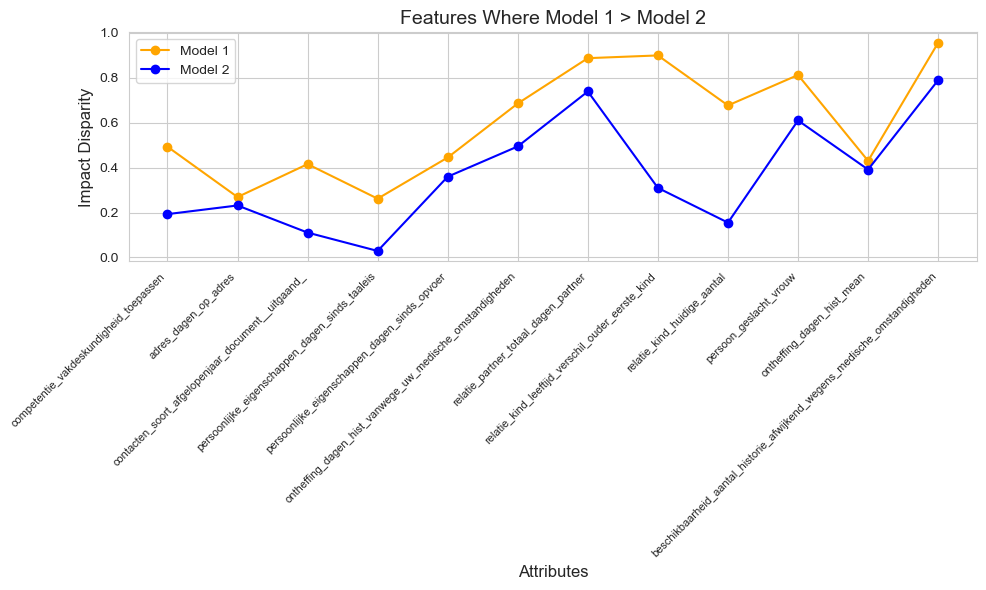

In [13]:
filtered_indices = [i for i in range(len(attributes)) if impact_model1[i] > impact_model2[i]]

filtered_attributes = [attributes[i] for i in filtered_indices]
filtered_model1 = [impact_model1[i] for i in filtered_indices]
filtered_model2 = [impact_model2[i] for i in filtered_indices]
x = np.arange(len(filtered_indices))

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x, filtered_model1, marker='o', color='orange', label='Model 1')
ax.plot(x, filtered_model2, marker='o', color='blue', label='Model 2')

ax.set_xlabel('Attributes', fontsize=12)
ax.set_ylabel('Impact Disparity', fontsize=12)
ax.set_title('Features Where Model 1 > Model 2', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(filtered_attributes, rotation=45, ha='right', fontsize=8)
ax.legend()
plt.tight_layout()
plt.show()

In [14]:
avg_model1 = np.mean(filtered_model1)
avg_model2 = np.mean(filtered_model2)

print("Average Impact Disparity (Model 1):", avg_model1)
print("Average Impact Disparity (Model 2):", avg_model2)

Average Impact Disparity (Model 1): 0.603028075920876
Average Impact Disparity (Model 2): 0.3679416004759557


Average Impact Disparity (Model 1): 0.38939088978320346
Average Impact Disparity (Model 2): 0.5055735039604735
